# *Gender Bias in Virtual Assistants Project*

### Identificando Preconceitos de Gênero em Assistentes Virtuais

![From Google](https://media-assets-01.thedrum.com/cache/images/thedrum-prod/s3-news-tmp-145694-untitled_design_70--default--1280.png)

### Equipe formada por
- Bárbara Stéphanie Neves Oliveira, 507526
- Lucas Benjamim Cunha Bandeira, 507533
- Samir Braga Chaves, 513788
- Vinicius Bernardo Gabriel, 475210


# *Schema-Guided Dialogue Dataset*

<center>
  <img width="500" src="https://drive.google.com/uc?id=1n7-dx6YyjwOKJFewyk0gtjNPD-0UB8OQ"/>
</center>

---

### Descrição do *Schema-Guided Dialogue* *Dataset*

- ***Schema* dos dados:**

```json
{
  "dialogue_id": "string",
  "services": {
    "[]": "string"
  },
  "turns": {
    "[]": {
      "frames": {
        "[]": {
          "actions": {
            "[]": {
              "act": [
                "string"
              ],
              "canonical_values": {
                "[]": "string"
              },
              "slot": "string",
              "values": {
                "[]": "string"
              }
            }
          },
          "service": "string",
          "service_call": {
            "method": "string",
            "parameters": {
              "[]": {
                "parameter_canonical_value": "string",
                "parameter_slot_name": "string"
              }
            }
          },
          "service_results": {
            "[]": {
              "service_results_list": {
                "[]": {
                  "service_canonical_value": "string",
                  "service_slot_name": "string"
                }
              }
            }
          },
          "slots": {
            "[]": {
              "exclusive_end": "int32",
              "slot": "string",
              "start": "int32"
            }
          },
          "state": {
            "active_intent": "string",
            "requested_slots": {
              "[]": "string"
            },
            "slot_values": {
              "[]": {
                "slot_name": "string",
                "slot_value_list": {
                  "[]": "string"
                }
              }
            }
          }
        }
      },
      "speaker": [
        "USER",
        "SYSTEM"
      ],
      "utterance": "string"
    }
  }
}
```

- **Sumário:** 
  - As partes relevantes para o nosso trabalho estão na feature `turns`, principalmente em no campo `utterance`, que é o texto em linguagem natural e o campo `speaker`, que indica quem disse o texto em `utterance`. Outros atributos que podemos levar em consideração é o tipo de serviço que está sendo prestado, dessa forma podemos avaliar a distribuição de viez de gênero e toxicidade dos comentários através dos domínios e serviços.
  - Campos do *schema* dos dados
    - `service_name` - nome único para o serviço
    - `description` - descrição em linguagem natural do serviço
    - `slots` - lista de atributos que correspondem as entidades presentes nos serviços. Cada *slot* posui os seguintes campos:
      - `name` - nome do *slot*
      - `description` - descrição do *slot* em linguagem natural
      - `is_categorical` - se verdadeiro, o *slot* pussui um conjunto fixo de valores
      - `possible_values` - lista de possíveis valores que o *slot* pode conter
      - `intents` - lista de tarefas suportadas pelo serviço. Contendo:
        - `name` - nome da tarefa
        - `description` - tarefa descrita em linguagem natural
        - `is_transactional` - valor booleano
        - `required_slots` - lista dos nomes dos *slots* necessários antes de chamar o serviço
        - `result_slots` - lista dos nomes dos *slots* que estão presentes nos resutados da chamada ao serviço

# Imports

In [ ]:
import pandas as pd
import numpy as np

from datasets import load_dataset, concatenate_datasets
import matplotlib.pyplot as plt
import seaborn as sns

# Pré-processamento de textos
import string
from spacy.lang.en import STOP_WORDS

CMAP_ICEFIRE = plt.get_cmap('icefire')
DEFAULT_FONT_SIZE = 14
plt.rcParams['font.size'] = DEFAULT_FONT_SIZE

BASE_PATH = '.'
DATASETS_PATH = BASE_PATH + "/resources/datasets"

In [ ]:
# Adicionando módulos customizados ao path
import sys
import warnings
warnings.filterwarnings('ignore')

sys.path.append(BASE_PATH + '/modules')
import utils
import text
from importlib import reload

# Leitura dos Dados

In [ ]:
dataset = load_dataset('schema_guided_dstc8', 'dialogues', cache_dir = DATASETS_PATH + "/SGD")

# Trabalhamos com todos os dados disponíveis
data = concatenate_datasets([dataset["train"], dataset["validation"], dataset["test"]])

# Realizando um flatten para transformar subestruturas em features
data = data.flatten()

Downloading:   0%|          | 0.00/3.45k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/22.0k [00:00<?, ?B/s]

Reusing dataset schema_guided_dstc8 (/content/drive/MyDrive/Ciência de Dados/Projeto Final/Resources/Datasets/SGD/schema_guided_dstc8/dialogues/0.0.0/198969f9783e0d5469f06a8200b63c78868e9834ba5f36529aee9e41c9bb02f2)


In [ ]:
# Transformando dados em um dataframe
df = data.to_pandas()

df['turns.speaker.utterance'] = df.apply(lambda x: list(zip(x[2], x[3])), axis =1)

# Filtrando apenas informações relevantes para o nosso trabalho: id do dialogo, serviços presentes no dialogo e as conversas: quem fala e o texto.
df = df[['dialogue_id', 'services', 'turns.speaker.utterance']]

# Transforma lista de pares em turns.speaker.utterance em novas linhas do dataset
df = df.explode('turns.speaker.utterance', ignore_index=True)

# Transforma pares em turns.speaker.utterance em duas colunas separadas
df[['speaker', 'utterance']] = pd.DataFrame(df['turns.speaker.utterance'].tolist())

df = df[['dialogue_id', 'services', 'speaker', 'utterance']]

# Removendo _ depois do nome do serviço
df['services'] = df['services'].map(lambda services: list(map(lambda s: s.split("_")[0], services)))

df.drop_duplicates(subset=["utterance", "speaker"], inplace=True)

df.head()

,dialogue_id,services,speaker,utterance
0,1_00000,[Restaurants],0,I am feeling hungry so I would like to find a ...
1,1_00000,[Restaurants],1,Do you have a specific which you want the eati...
2,1_00000,[Restaurants],0,I would like for it to be in San Jose.
3,1_00000,[Restaurants],1,"Is there a specific cuisine type you enjoy, su..."
4,1_00000,[Restaurants],0,I usually like eating the American type of food.


In [ ]:
print('Número de instâncias = {}'.format(len(df)))
print('Número de atributos = {}'.format(len(df.columns)))

Número de instâncias = 335960
Número de atributos = 4


# Pré-processamento dos Dados

Como já realizamos uma análise exploratória do **SGD *dataset*** e guardamos algumas informações especificamente para a etapa de pré-processamento, executaremos os seguintes passos para treinamento e avaliação dos modelos com o presente conjunto de dados: 

1. Limpeza dos dados e remoção das *stopwords*
2. Seleção de uma *sample* para treino e avaliação com base em um *threshold* 



## Limpeza dos Dados e Remoção das *Stopwords*

Nesta etapa, iremos repetir o que foi feito no *notebook* de EDA.

In [ ]:
df.head()

,dialogue_id,services,speaker,utterance
0,1_00000,[Restaurants],0,I am feeling hungry so I would like to find a ...
1,1_00000,[Restaurants],1,Do you have a specific which you want the eati...
2,1_00000,[Restaurants],0,I would like for it to be in San Jose.
3,1_00000,[Restaurants],1,"Is there a specific cuisine type you enjoy, su..."
4,1_00000,[Restaurants],0,I usually like eating the American type of food.


In [ ]:
df['utterance_tokens'] = df['utterance'].apply(lambda r: r.translate(str.maketrans('', '', string.punctuation)).lower().split()) 
df['clean_utterance'] = df['utterance_tokens'].apply(lambda x: ' '.join(x))
df['utterance_tokens_count'] = df['utterance_tokens'].apply(lambda r: len(r)) # Quantidade de tokens de cada texto

all_utterance_tokens = df['utterance_tokens'].explode() 
all_utterance_clean_tokens = [token for token in all_utterance_tokens if token not in STOP_WORDS]

# Corta palavras que aparecem mais de 7000 vezes
frequency_cut = 7000

most_common_clean_tokens = utils.make_most_common_words(all_utterance_clean_tokens, n_most_common=50)
words2ignore = [tup[0] for tup in most_common_clean_tokens if tup[1] > frequency_cut] # Valor que estava no notebook de EDA
set_stop_words2ignore = STOP_WORDS.union(set(words2ignore))

df['utterance_tokens'] = df['utterance_tokens'].apply(lambda x: text.remove_potencial_stopwords(x, words2ignore=set_stop_words2ignore))
df['clean_utterance_words2ignore'] = df['utterance_tokens'].apply(lambda x: ' '.join(x))

df.head()

,dialogue_id,services,speaker,utterance,utterance_tokens,clean_utterance,utterance_tokens_count,clean_utterance_words2ignore
0,1_00000,[Restaurants],0,I am feeling hungry so I would like to find a ...,"[feeling, hungry, place, eat]",i am feeling hungry so i would like to find a ...,14,feeling hungry place eat
1,1_00000,[Restaurants],1,Do you have a specific which you want the eati...,"[specific, eating, place, located]",do you have a specific which you want the eati...,15,specific eating place located
2,1_00000,[Restaurants],0,I would like for it to be in San Jose.,[jose],i would like for it to be in san jose,10,jose
3,1_00000,[Restaurants],1,"Is there a specific cuisine type you enjoy, su...","[specific, cuisine, type, enjoy, mexican, ital...",is there a specific cuisine type you enjoy suc...,15,specific cuisine type enjoy mexican italian
4,1_00000,[Restaurants],0,I usually like eating the American type of food.,"[usually, eating, american, type, food]",i usually like eating the american type of food,9,usually eating american type food


In [ ]:
print('Estatísticas básicas da contagem de tokens dos dialogos =\n{}\n'.format(df['utterance_tokens_count'].describe()))

# Todos os tokens dos dialogos
all_utterance_tokens = df['utterance_tokens'].explode() 

print('Quantidade de palavras de todos os diálogos = {}'.format(len(list(all_utterance_tokens))))
print('Quantidade de palavras ÚNICAS de todos os diálogos = {}'.format(len(set(all_utterance_tokens))))

Estatísticas básicas da contagem de tokens dos dialogos =
count    335960.000000
mean         11.709590
std           6.608093
min           0.000000
25%           7.000000
50%          10.000000
75%          15.000000
max          84.000000
Name: utterance_tokens_count, dtype: float64

Quantidade de palavras de todos os diálogos = 1300521
Quantidade de palavras ÚNICAS de todos os diálogos = 22102


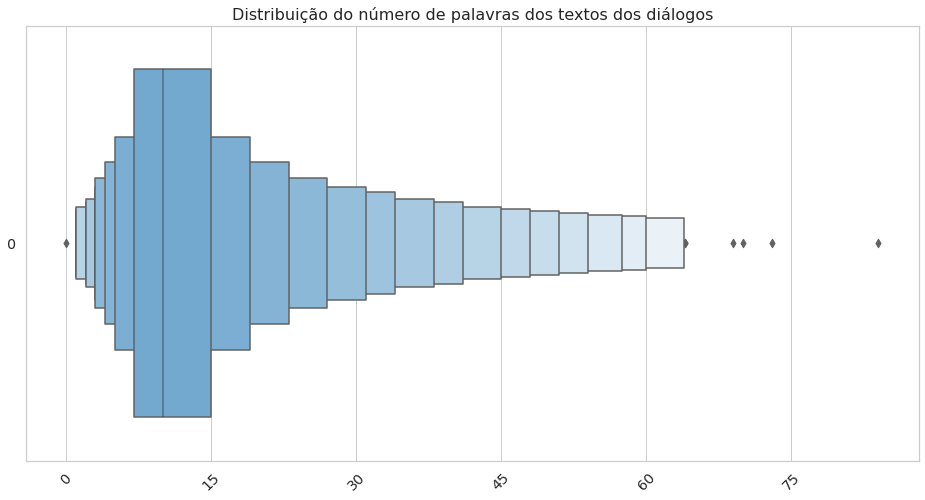

In [ ]:
utterance_tokens_percentil_75 = df['utterance_tokens_count'].describe()['75%']

utils.plot_distribution_large_data(df['utterance_tokens_count'], 
                                   title='Distribuição do número de palavras dos textos dos diálogos', 
                                   xaxis_interval=utterance_tokens_percentil_75)

## *Sample* Final dos Dados

Aqui, iremos selecionar mais uma *sample* do conjunto de dados. Como o intuito final do presente trabalho consiste em unir as predições de dois modelos diferentes (um para identificação de viés de gênero e outro para toxicidade), precisamos escolher um valor de *threshold* para o tamanho dos textos. Este valor também é usado no *notebook* de pré-processamento para os *datasets* anotados conforme o gênero. Nossos modelos precisam receber textos que possuam uma quantidade de palavras proporcional.

- Valor do *threshold* = até 60 palavras

In [ ]:
print('Número de instâncias = {}'.format(len(df)))

df = df[df['utterance_tokens_count'] > 1] # Retirando textos que possuem apenas uma palavra (ou nenhuma)
df = df[df['utterance_tokens_count'] <= text.MAX_LENGTH]
print('Número de instâncias após a remoção = {}'.format(len(df)))

Número de instâncias = 335960
Número de instâncias após a remoção = 335408


In [ ]:
df

,dialogue_id,services,speaker,utterance,utterance_tokens,clean_utterance,utterance_tokens_count,clean_utterance_words2ignore
0,1_00000,[Restaurants],0,I am feeling hungry so I would like to find a ...,"[feeling, hungry, place, eat]",i am feeling hungry so i would like to find a ...,14,feeling hungry place eat
1,1_00000,[Restaurants],1,Do you have a specific which you want the eati...,"[specific, eating, place, located]",do you have a specific which you want the eati...,15,specific eating place located
2,1_00000,[Restaurants],0,I would like for it to be in San Jose.,[jose],i would like for it to be in san jose,10,jose
3,1_00000,[Restaurants],1,"Is there a specific cuisine type you enjoy, su...","[specific, cuisine, type, enjoy, mexican, ital...",is there a specific cuisine type you enjoy suc...,15,specific cuisine type enjoy mexican italian
4,1_00000,[Restaurants],0,I usually like eating the American type of food.,"[usually, eating, american, type, food]",i usually like eating the american type of food,9,usually eating american type food
...,...,...,...,...,...,...,...,...
463276,34_00053,"[Hotels, Travel]",0,I need two rooms at the hotel you found beginn...,"[rooms, beginning, 12th]",i need two rooms at the hotel you found beginn...,16,rooms beginning 12th
463277,34_00053,"[Hotels, Travel]",1,"Please confirm, checking in the Ac Hotel by Ma...","[checking, ac, marriott, paris, porte, maillot...",please confirm checking in the ac hotel by mar...,29,checking ac marriott paris porte maillot paris...
463278,34_00053,"[Hotels, Travel]",0,Thanks! That is great.,[],thanks that is great,4,
463280,34_00053,"[Hotels, Travel]",0,Is smoking permitted? What is the price per ni...,"[smoking, permitted, price, night]",is smoking permitted what is the price per night,9,smoking permitted price night


Como podemos ver, existem instâncias que tem uma lista vazia de *tokens*, pois a frase era composta apenas por *stopwords* ou palavras que tinham frequência muito grande, como a frase "*Thanks! That is great*". Abaixo, removemos essas linhas do *dataframe*.

In [ ]:
print(f"Quantidade de linhas com zero tokens: {len(df[df['utterance_tokens'].str.len() == 0])}")
print(f"Numero de linhas antes da remoção: {len(df)}")
df = df[df['utterance_tokens'].str.len() > 0]
print(f"Numero de linhas apos a remoção: {len(df)}")

Quantidade de linhas com zero tokens: 17088
Numero de linhas antes da remoção: 335408
Numero de linhas apos a remoção: 318320


In [ ]:
df.to_csv(BASE_PATH + '/resources/datasets/SGD/new_data.csv', index=False)

# Observações 

*Só isso de pré-processamento? E a representação textual? E os rótulos? Ficam assim mesmo?*

Paciência, gafanhoto. Quem espera sempre alcança! 

No que diz respeito aos rótulos, eles estão no formato ideal. Enquanto que os textos ainda precisam passar por algumas mudanças para serem usados como entrada para os modelos. Este passo será feito na etapa de treinamento ;)